# Genesis4 FODO Scan

LUME-Genesis makes it easy to explore a parameter space within a notebook.

Here we will make a lattice file within the notebook, and scan the quadrupole k to find the best final power for a simple benchmark example.

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
from genesis.version4 import Genesis4
from lume.tools import full_path
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Lattice

Here we will use [Genesis4 SASE Benchmark](https://github.com/svenreiche/Genesis-1.3-Version4/blob/dev/benchmark/Benchmark1-SASE/Aramis.lat) as the basis for a lattice, but create it here in code.

Note that the FODO cell length is 9.5 m, and there are 13 cells, for a total length of 123.5 m.

In [3]:
LATFILE = 'data/genesis4_fodo.lat'

def make_lat(k1=2, latfile=LATFILE):
    lat = f"""
D1: DRIFT = {{ l = 0.445}};
D2: DRIFT = {{ l = 0.24}};
QF: QUADRUPOLE = {{ l = 0.080000, k1= {k1} }};
QD: QUADRUPOLE = {{ l = 0.080000, k1= {-k1} }};

UND: UNDULATOR = {{ lambdau=0.015000,nwig=266,aw=0.84853}};

FODO: LINE= {{UND,D1,QF,D2,UND,D1,QD,D2}};

ARAMIS: LINE= {{13*FODO}};
    """
    with open(latfile, 'w') as f:
        f.write(lat)
        
    return full_path(latfile)
    
make_lat()
!cat {LATFILE}


D1: DRIFT = { l = 0.445};
D2: DRIFT = { l = 0.24};
QF: QUADRUPOLE = { l = 0.080000, k1= 2 };
QD: QUADRUPOLE = { l = 0.080000, k1= -2 };

UND: UNDULATOR = { lambdau=0.015000,nwig=266,aw=0.84853};

FODO: LINE= {UND,D1,QF,D2,UND,D1,QD,D2};

ARAMIS: LINE= {13*FODO};
    

In [4]:
FILE = 'data/aramis/genesis4.in'
G = Genesis4()
INPUT0 = {'main': [{'type': 'setup',
   'rootname': 'Benchmark',
   'lattice': make_lat(k1=2),
   'beamline': 'ARAMIS',
   'lambda0': 1e-10,
   'gamma0': 11357.82,
   'delz': 0.045,
   'shotnoise': 0,
   'beam_global_stat': True,
   'field_global_stat': True},
  {'type': 'lattice', 'zmatch': 9.5},
  {'type': 'field',
   'power': 5000,
   'dgrid': 0.0002,
   'ngrid': 255,
   'waist_size': 3e-05},
  {'type': 'beam', 'current': 3000, 'delgam': 1, 'ex': 4e-07, 'ey': 4e-07},
  {'type': 'track', 'zstop': 123.5}]}
G.input = deepcopy(INPUT0)

In [5]:
%%time
G.nproc=8
G.run()

CPU times: user 9.21 ms, sys: 5.48 ms, total: 14.7 ms
Wall time: 12.5 s


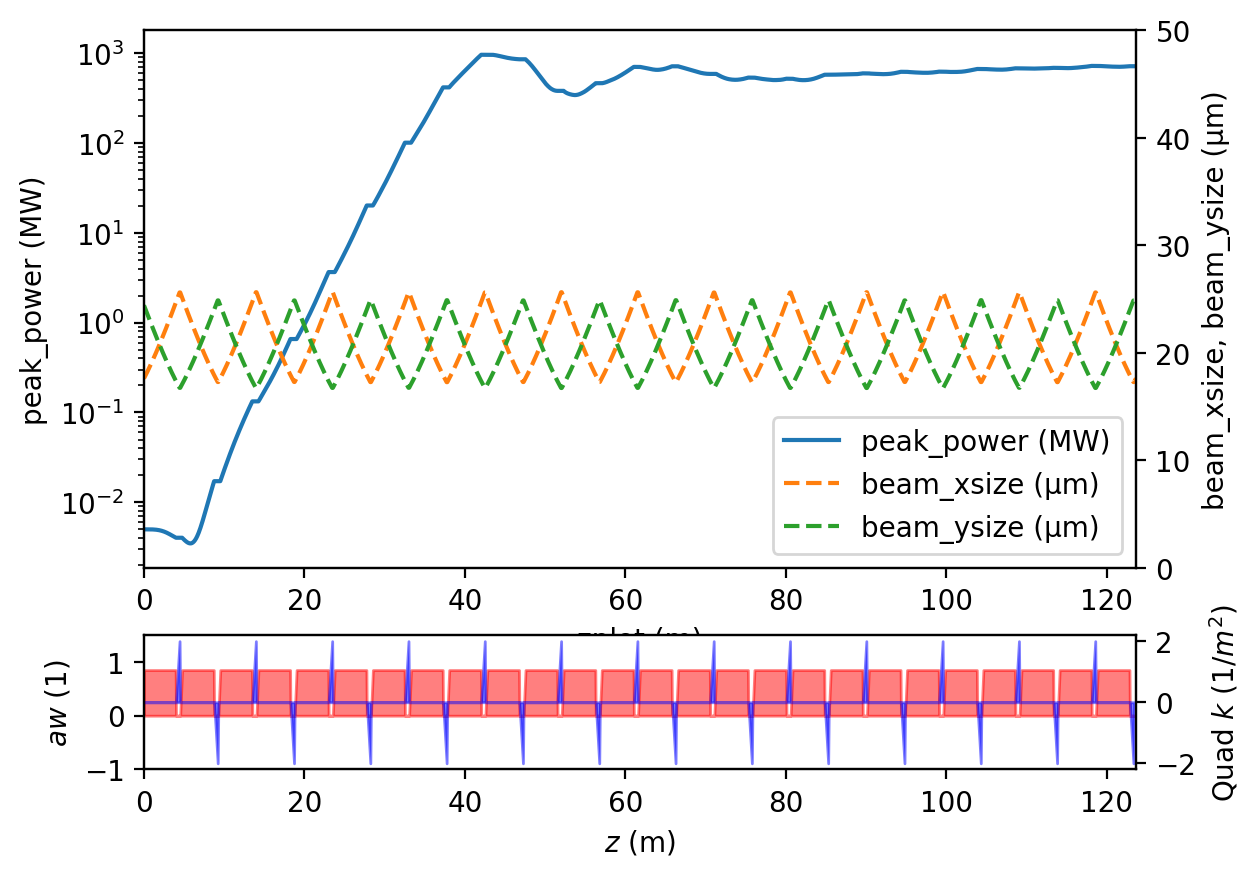

In [6]:
G.plot('power', yscale='log', y2=['beam_xsize', 'beam_ysize'], ylim2=(0,50e-6))

# Run1 function

Make a simple function to run a complete simulation and return a `Genesis4` object.

In [7]:
%%time
def run1(k):
    make_lat(k)
    G = Genesis4()
    G.input = deepcopy(INPUT0)
    G.input['main'][0]['lattice'] = full_path(LATFILE)
    G.input['main'][-1]['zstop'] = 20  
    G.nproc = 8
    G.run()
    return G

G2=run1(4)

CPU times: user 8.89 ms, sys: 6 ms, total: 14.9 ms
Wall time: 2.11 s


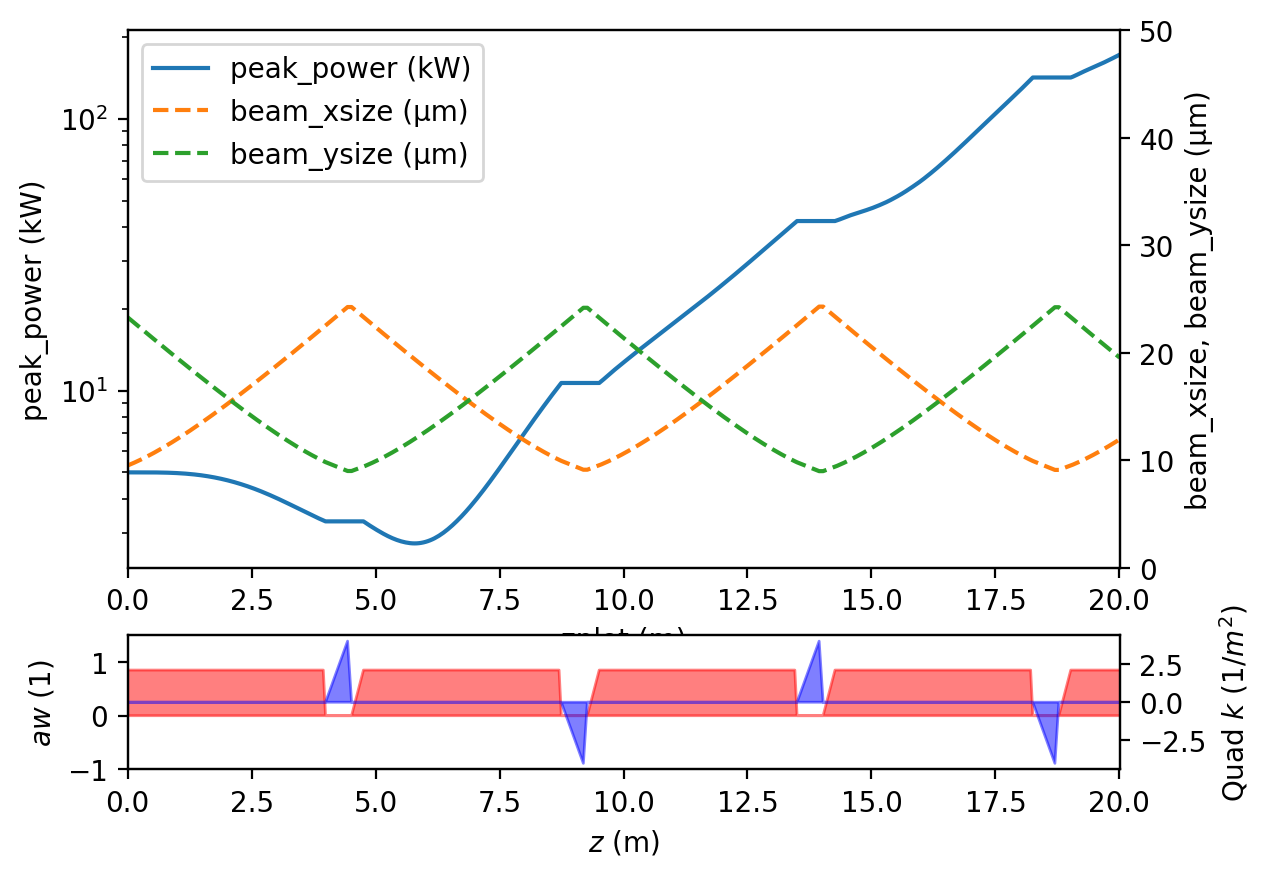

In [8]:
G2.plot('power', yscale='log', y2=['beam_xsize', 'beam_ysize'], ylim2=(0, 50e-6))

# Scan k1

Now scan use this function to scan various quadrupole k1. Note that Genesis4 is doing matching internally with `zmatch` in the input.

In [9]:
%%time
klist = np.linspace(1, 3, 10)
Glist = [run1(k) for k in klist]

CPU times: user 89.1 ms, sys: 49 ms, total: 138 ms
Wall time: 21.7 s


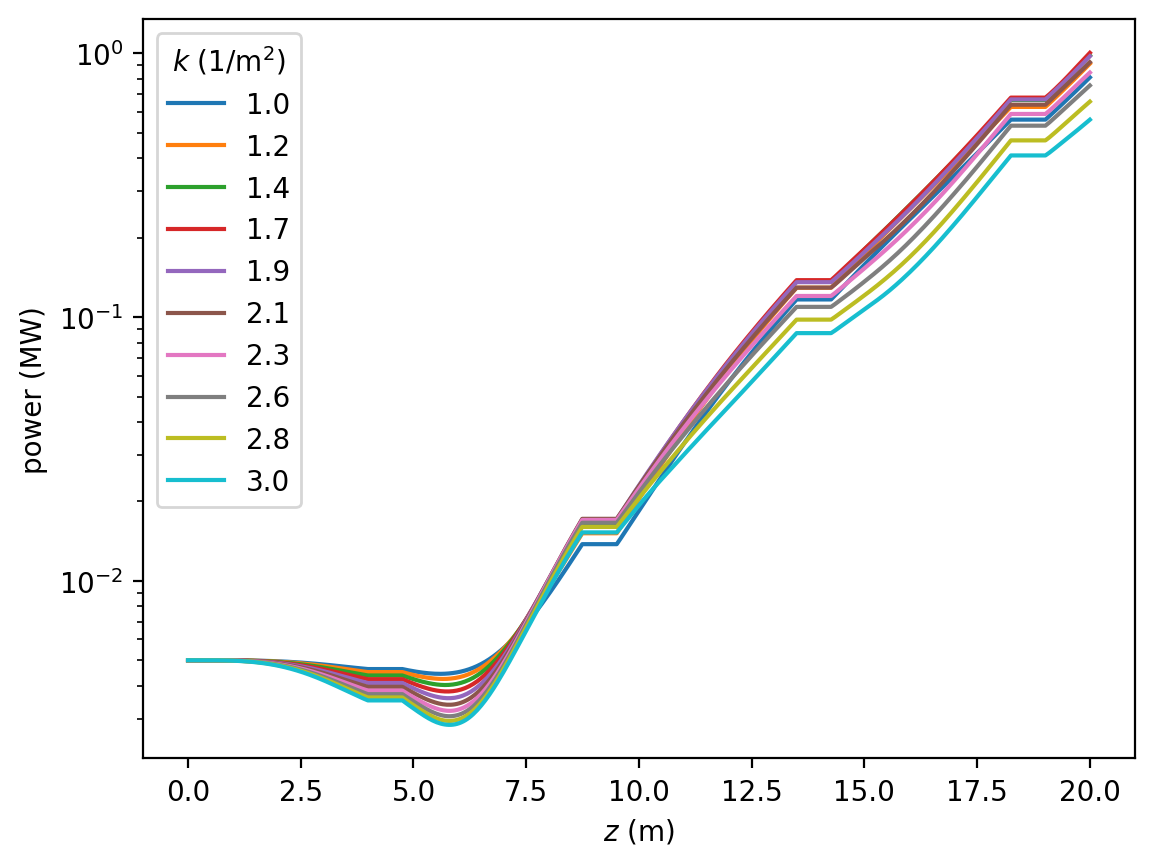

In [10]:
fig, ax = plt.subplots()
for k, g in zip(klist, Glist):
    x = g.stat('zplot')
    y = g.stat('power')
    ax.plot(x, y/1e6, label = f'{k:0.1f}')
ax.set_yscale('log')
ax.set_xlabel(r'$z$ (m)')
ax.set_ylabel('power (MW)')
plt.legend(title = r'$k$ (1/m$^2$)')

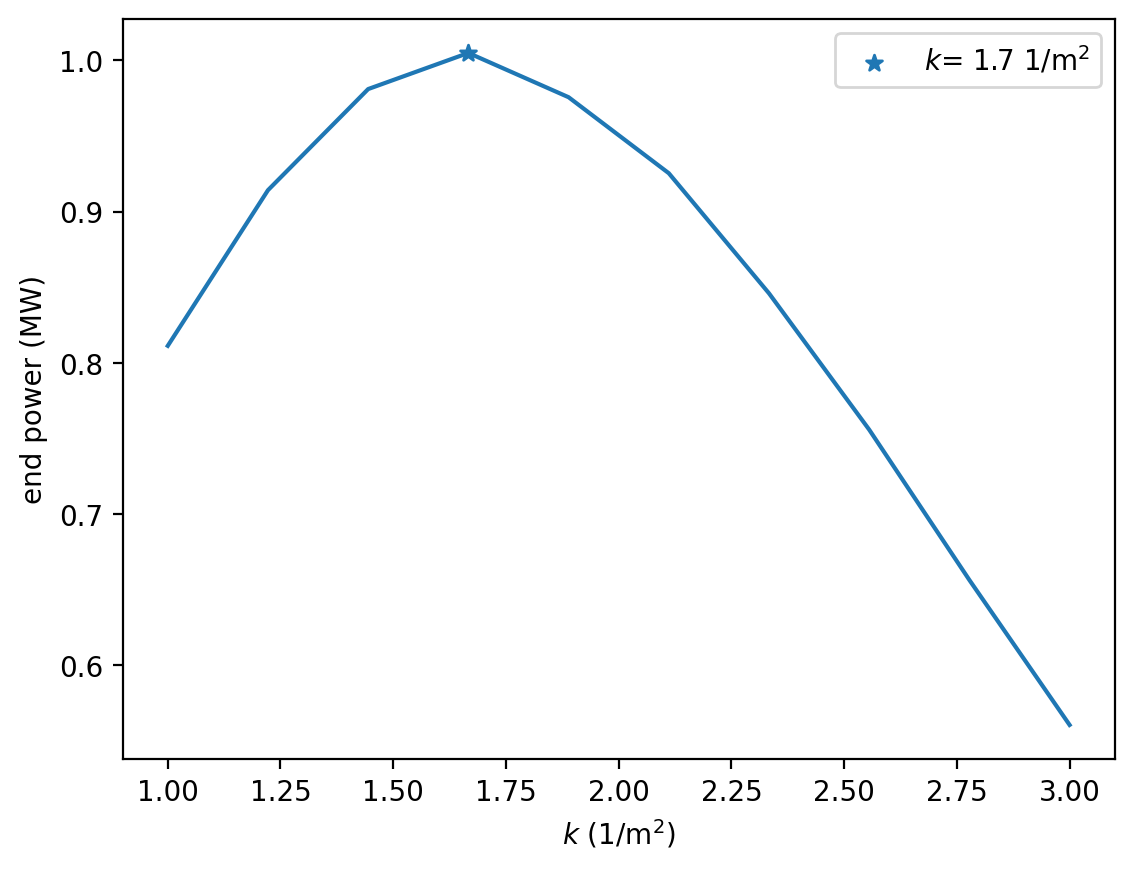

In [11]:
fig, ax = plt.subplots()
y = np.array([g.stat('power')[-1] for g in Glist])
ixbest = y.argmax()
Gbest = Glist[ixbest]
kbest = klist[ixbest]
ybest = y[ixbest]
ax.plot(klist, y/1e6 )
ax.scatter(kbest, ybest/1e6, marker='*', label=fr'$k$= {kbest:0.1f} 1/m$^2$') 
ax.set_ylabel('end power (MW)')
ax.set_xlabel(r'$k$ (1/m$^2$)')
plt.legend()

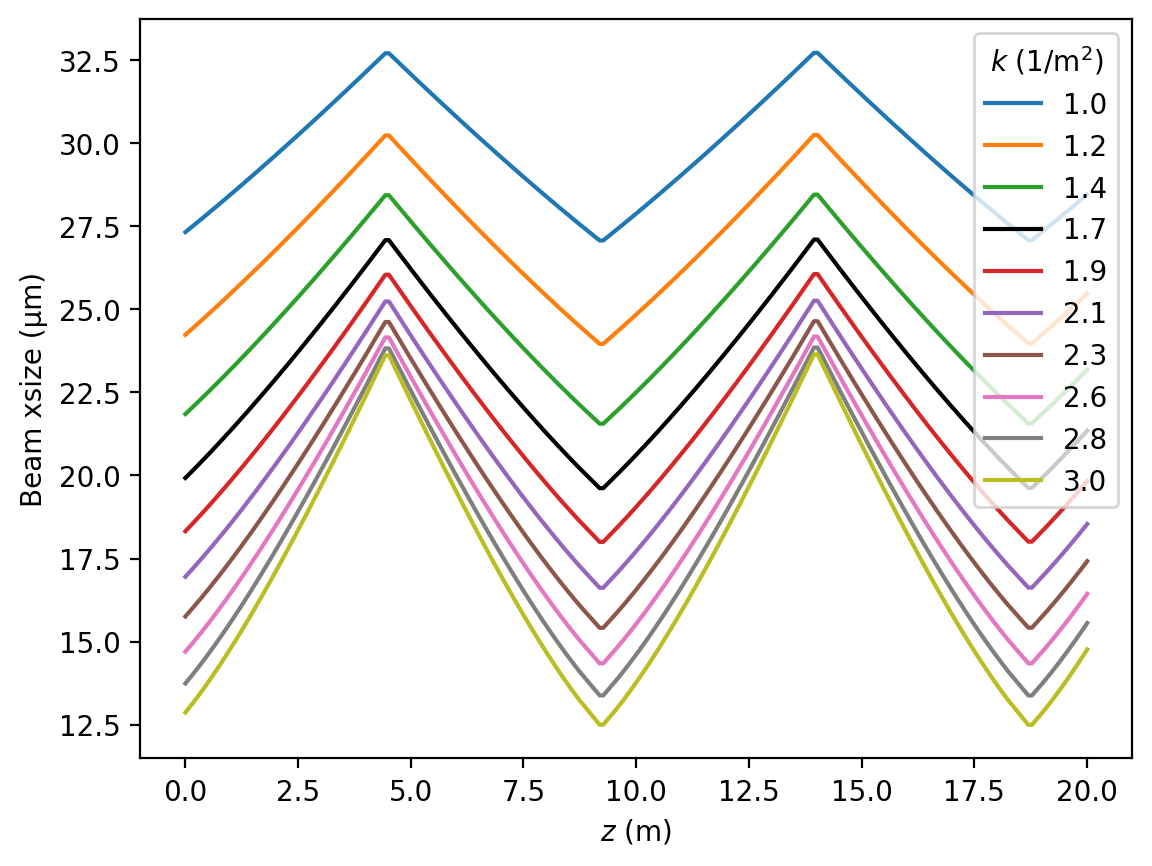

In [12]:
fig, ax = plt.subplots()
for k, g in zip(klist, Glist):
    x = g.stat('zplot')
    y = g.stat('beam_xsize')
    if k == kbest:
        color = 'black'
    else:
        color = None
    ax.plot(x, y*1e6, label = f'{k:0.1f}', color=color)

ax.set_xlabel(r'$z$ (m)')
ax.set_ylabel('Beam xsize (µm)')  
#ax.set_ylim(0, None)
plt.legend(title = r'$k$ (1/m$^2$)')

Cleanup

In [13]:
os.remove(LATFILE)